## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [215]:
#install.packages('tsibble')
#install.packages('fable')
#install.packages('fabletools')
#install.packages('BVAR')
#install.packages('feasts')
##install.packages("urca")
#install.packages('tseries')
library(tidyverse)
library(tsibble)
library(fable)
library(fabletools)
library(stats)
library(BVAR)
library(feasts)
library(urca)
library(tseries)
library(ggplot2)
library(lubridate)

## 2) Main Section for Code
### Preparing dataset for analysis and applying the relevant stationarity-inducing transformations to the variables.

In [166]:
data = read.csv("https://raw.githubusercontent.com/dsesc-acads/Databusters/refs/heads/main/Quarterly%20Data.csv")
data = data[-c(1:38),]
data <- data %>%
  dplyr::select('sasdate', "GDPC1", 'GS10TB3Mx', 'CLAIMSx', 'ANDENOx', 'UMCSENTx', 'HOUST') %>%
  mutate(sasdate = yearquarter(sasdate))
transformed <- fred_transform(data[,-1], type=c('fred_qd'), codes=c(5,1,5,5,2,5))
transformed <- cbind(data$sasdate[-1], transformed) %>%
  rename(date = 'data$sasdate[-1]') %>%
  mutate(GDPC1 = 4 * GDPC1) %>%
  as_tsibble(index=date)

transformed <- transformed %>%
  mutate(across(c(GS10TB3Mx, CLAIMSx, ANDENOx, UMCSENTx, GDPC1, HOUST),
                 list(lag1 = ~ lag(., 1), lag2 = ~ lag(., 2),lag3 = ~ lag(., 3), lag4 = ~ lag(., 4)),
                 .names = "{col}_{fn}"))

transformed <- transformed[-c(1:4),]

ADF test to check for stationarity

In [167]:
adf.test(transformed$GDPC1)
adf.test(transformed$GS10TB3Mx)
adf.test(transformed$CLAIMSx)
adf.test(transformed$ANDENOx)
adf.test(transformed$UMCSENTx)
adf.test(transformed$HOUST)


Warning message in adf.test(transformed$GDPC1):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  transformed$GDPC1
Dickey-Fuller = -6.0771, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  transformed$GS10TB3Mx
Dickey-Fuller = -3.7879, Lag order = 6, p-value = 0.02052
alternative hypothesis: stationary


Warning message in adf.test(transformed$CLAIMSx):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  transformed$CLAIMSx
Dickey-Fuller = -7.3545, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(transformed$ANDENOx):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  transformed$ANDENOx
Dickey-Fuller = -5.9177, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(transformed$UMCSENTx):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  transformed$UMCSENTx
Dickey-Fuller = -6.1678, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(transformed$HOUST):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  transformed$HOUST
Dickey-Fuller = -4.9351, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


## 3) AR Lag Selection
### Preparing dataset for analysis and applying the relevant stationarity-inducing transformations to the variables.

In [168]:
ar_lags <- transformed[1:215,] %>%
  model(ar1 = AR(GDPC1 ~ order(1)),
        ar2 = AR(GDPC1 ~ order(2)),
        ar3 = AR(GDPC1 ~ order(3)),
        ar4 = AR(GDPC1 ~ order(4)))

glance(ar_lags) %>%
  arrange(AIC)

ar_lags %>%
  fabletools::forecast(new_data=transformed[216:219,]) %>%
  accuracy(transformed)

tidy(ar_lags)

.model,sigma2,AIC,AICc,BIC,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ar1,19.39081,3.887315,3.943918,10.62859,213
ar2,19.41131,6.114516,6.228260,16.22643,212
ar3,19.38513,7.824285,8.014761,21.30684,211
ar4,19.42438,10.259214,10.546295,27.11240,210


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ar1,Test,0.4649493,0.8348992,0.5954848,10.95524,16.34803,0.1590267,0.1343137,-0.2781114
ar2,Test,0.4542497,0.8372748,0.6037337,10.52520,16.70080,0.1612296,0.1346959,-0.2835602
ar3,Test,0.4484738,0.8205455,0.6083450,10.43221,17.03695,0.1624611,0.1320046,-0.3238528
ar4,Test,0.4454774,0.8117210,0.6028504,10.39569,16.89720,0.1609937,0.1305850,-0.3419946


.model,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ar1,constant,2.688127740,0.35207521,7.63509515,7.498689e-13
ar1,ar1,-0.002425178,0.06834389,-0.03548493,9.717263e-01
ar2,constant,2.527324232,0.39780044,6.35324638,1.267488e-09
ar2,ar1,-0.002298229,0.06839786,-0.03360089,9.732270e-01
ar2,ar2,0.060152172,0.06838021,0.87967219,3.800330e-01
ar3,constant,2.473296151,0.43431362,5.69472386,4.111170e-08
ar3,ar1,-0.004270275,0.06847745,-0.06236032,9.503349e-01
ar3,ar2,0.058614618,0.06835190,0.85754197,3.921184e-01
ar3,ar3,0.031642410,0.06850717,0.46188464,6.446399e-01


Selection of lags of other predictors:

In [169]:
### Term Spread
ardl_spread<- transformed[1:215,] %>%
  model(AR(GDPC1 ~ order(1)),
        AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1),
        AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2),
        AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + GS10TB3Mx_lag3),
        AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + GS10TB3Mx_lag3 + GS10TB3Mx_lag4))

glance(ardl_spread) %>%
  arrange(AIC)

ardl_spread %>%
  fabletools::forecast(new_data=transformed[216:219,]) %>%
  accuracy(transformed)

.model,sigma2,AIC,AICc,BIC,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2),18.18772,-5.884038,-5.693562,7.598514,211
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + GS10TB3Mx_lag3),18.15880,-4.226142,-3.939061,12.627048,210
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + GS10TB3Mx_lag3 + GS10TB3Mx_lag4),18.12433,-2.634605,-2.230759,17.589223,209
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1),18.69201,-2.003878,-1.890134,8.108036,212
AR(GDPC1 ~ order(1)),19.39081,3.887315,3.943918,10.628591,213


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + GS10TB3Mx_lag3 + GS10TB3Mx_lag4),Test,1.8978953,2.3138050,1.8978953,55.20913,55.20913,0.5068409,0.3722315,0.1878086
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + GS10TB3Mx_lag3),Test,2.0000153,2.3900285,2.0000153,59.10982,59.10982,0.5341125,0.3844939,0.2469661
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2),Test,2.1353886,2.4682678,2.1353886,63.73273,63.73273,0.5702645,0.3970806,0.2144260
AR(GDPC1 ~ order(1) + GS10TB3Mx_lag1),Test,2.2503848,2.4340597,2.2503848,69.00876,69.00876,0.6009747,0.3915774,-0.0793700
AR(GDPC1 ~ order(1)),Test,0.4649493,0.8348992,0.5954848,10.95524,16.34803,0.1590267,0.1343137,-0.2781114


In [170]:
### Unemployment claims
ardl_claims<- transformed[1:215,] %>%
  model(AR(GDPC1 ~ order(1)),
        AR(GDPC1 ~ order(1) + CLAIMSx_lag1),
        AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2),
        AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2 + CLAIMSx_lag3),
        AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2 + CLAIMSx_lag3 + CLAIMSx_lag4))

glance(ardl_claims) %>%
  arrange(AIC)


.model,sigma2,AIC,AICc,BIC,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2 + CLAIMSx_lag3 + CLAIMSx_lag4),15.04411,-42.682365,-42.278518,-22.45854,209
AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2 + CLAIMSx_lag3),15.26594,-41.535387,-41.248306,-24.68220,210
AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2),15.45349,-40.910092,-40.719616,-27.42754,211
AR(GDPC1 ~ order(1) + CLAIMSx_lag1),16.25040,-32.099198,-31.985454,-21.98728,212
AR(GDPC1 ~ order(1)),19.39081,3.887315,3.943918,10.62859,213


In [171]:
### New orders of capital goods
ardl_andeno<- transformed[1:215,] %>%
  model(AR(GDPC1 ~ order(1)),
        AR(GDPC1 ~ order(1) + ANDENOx_lag1),
        AR(GDPC1 ~ order(1) + ANDENOx_lag1 + ANDENOx_lag2),
        AR(GDPC1 ~ order(1) + ANDENOx_lag1 + ANDENOx_lag2 + ANDENOx_lag3),
        AR(GDPC1 ~ order(1) + ANDENOx_lag1 + ANDENOx_lag2 + ANDENOx_lag3 + ANDENOx_lag4))

glance(ardl_andeno) %>%
  arrange(AIC)


.model,sigma2,AIC,AICc,BIC,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
AR(GDPC1 ~ order(1) + ANDENOx_lag1 + ANDENOx_lag2),18.53431,-1.8254707,-1.6349945,11.65708,211
AR(GDPC1 ~ order(1) + ANDENOx_lag1 + ANDENOx_lag2 + ANDENOx_lag3),18.47990,-0.4575456,-0.1704643,16.39564,210
AR(GDPC1 ~ order(1) + ANDENOx_lag1 + ANDENOx_lag2 + ANDENOx_lag3 + ANDENOx_lag4),18.43130,0.9763187,1.3801648,21.20015,209
AR(GDPC1 ~ order(1)),19.39081,3.8873146,3.9439184,10.62859,213
AR(GDPC1 ~ order(1) + ANDENOx_lag1),19.39060,5.8850083,5.9987524,15.99692,212


In [172]:
### Consumer Sentiment Index
ardl_csent <- transformed[1:215,] %>%
  model(AR(GDPC1 ~ order(1)),
        AR(GDPC1 ~ order(1) + UMCSENTx_lag1),
        AR(GDPC1 ~ order(1) + UMCSENTx_lag1 + UMCSENTx_lag2),
        AR(GDPC1 ~ order(1) + UMCSENTx_lag1 + UMCSENTx_lag2 + UMCSENTx_lag3),
        AR(GDPC1 ~ order(1) + UMCSENTx_lag1 + UMCSENTx_lag2 + UMCSENTx_lag3 + UMCSENTx_lag4))

glance(ardl_csent) %>%
  arrange(AIC)


.model,sigma2,AIC,AICc,BIC,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
AR(GDPC1 ~ order(1) + UMCSENTx_lag1 + UMCSENTx_lag2 + UMCSENTx_lag3 + UMCSENTx_lag4),18.51930,2.000300,2.404146,22.22413,209
AR(GDPC1 ~ order(1) + UMCSENTx_lag1 + UMCSENTx_lag2 + UMCSENTx_lag3),18.81839,3.444946,3.732027,20.29814,210
AR(GDPC1 ~ order(1)),19.39081,3.887315,3.943918,10.62859,213
AR(GDPC1 ~ order(1) + UMCSENTx_lag1 + UMCSENTx_lag2),19.06065,4.195016,4.385493,17.67757,211
AR(GDPC1 ~ order(1) + UMCSENTx_lag1),19.35868,5.530801,5.644545,15.64272,212


In [173]:
ardl_houst <- transformed[1:215,] %>%
  model(AR(GDPC1 ~ order(1)),
        AR(GDPC1 ~ order(1) + HOUST_lag1),
        AR(GDPC1 ~ order(1) + HOUST_lag1 + HOUST_lag2),
        AR(GDPC1 ~ order(1) + HOUST_lag1 + HOUST_lag2 + HOUST_lag3),
        AR(GDPC1 ~ order(1) + HOUST_lag1 + HOUST_lag2 + HOUST_lag3 + HOUST_lag4))

glance(ardl_houst) %>%
  arrange(AIC)

.model,sigma2,AIC,AICc,BIC,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
AR(GDPC1 ~ order(1) + HOUST_lag1 + HOUST_lag2 + HOUST_lag3),17.58143,-11.173198,-10.886117,5.679992,210
AR(GDPC1 ~ order(1) + HOUST_lag1 + HOUST_lag2 + HOUST_lag3 + HOUST_lag4),17.56663,-9.354332,-8.950486,10.869496,209
AR(GDPC1 ~ order(1) + HOUST_lag1 + HOUST_lag2),17.96522,-8.530439,-8.339963,4.952113,211
AR(GDPC1 ~ order(1) + HOUST_lag1),18.66334,-2.333903,-2.220159,7.778011,212
AR(GDPC1 ~ order(1)),19.39081,3.887315,3.943918,10.628591,213


In [174]:
ardl_combined <- transformed[1:215,] %>%
  model(AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2 + CLAIMSx_lag3 + CLAIMSx_lag4 + ANDENOx_lag1 + ANDENOx_lag2 + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + UMCSENTx_lag1 + UMCSENTx_lag2 + UMCSENTx_lag3 + UMCSENTx_lag4 + HOUST_lag1 + HOUST_lag2 + HOUST_lag3))

glance(ardl_combined)

ardl_combined %>%
  fabletools::forecast(new_data=transformed[216:219,]) %>%
  accuracy(transformed)



.model,sigma2,AIC,AICc,BIC,dof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2 + CLAIMSx_lag3 + CLAIMSx_lag4 + ANDENOx_lag1 + ANDENOx_lag2 + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + UMCSENTx_lag1 + UMCSENTx_lag2 + UMCSENTx_lag3 + UMCSENTx_lag4 + HOUST_lag1 + HOUST_lag2 + HOUST_lag3),10.78291,-92.28266,-89.17606,-34.98181,198


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AR(GDPC1 ~ order(1) + CLAIMSx_lag1 + CLAIMSx_lag2 + CLAIMSx_lag3 + CLAIMSx_lag4 + ANDENOx_lag1 + ANDENOx_lag2 + GS10TB3Mx_lag1 + GS10TB3Mx_lag2 + UMCSENTx_lag1 + UMCSENTx_lag2 + UMCSENTx_lag3 + UMCSENTx_lag4 + HOUST_lag1 + HOUST_lag2 + HOUST_lag3),Test,1.217375,2.181504,2.059469,39.16988,65.9684,0.5499898,0.3509477,-0.3288316


VAR

In [175]:
var <- transformed[1:215,] %>%
  model(var1 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx, ANDENOx, HOUST) ~ AR(1)),
        var2 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx, ANDENOx, HOUST) ~ AR(2)),
        var3 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx, ANDENOx, HOUST) ~ AR(3)),
        var4 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx, ANDENOx, HOUST) ~ AR(4)))


for (i in 1:4){
   print(sprintf("AIC of VAR %s is %s", i, var[[i]][[1]][["fit"]][["fit"]][["AIC"]]))
}

var %>%
  fabletools::forecast(new_data=transformed[216:219,]) %>%
  accuracy(transformed) %>%
  filter(.response == 'GDPC1') %>%
  arrange(RMSE)


[1] "AIC of VAR 1 is 7409.27755768287"
[1] "AIC of VAR 2 is 7317.09559771354"
[1] "AIC of VAR 3 is 7325.64587576418"
[1] "AIC of VAR 4 is 7302.2307184856"


.model,.response,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
var1,GDPC1,Test,1.551045,1.667352,1.551045,47.76156,47.76156,0.4142132,0.2682339,-0.3906258
var2,GDPC1,Test,2.120961,2.218015,2.120961,66.89606,66.89606,0.5664117,0.3568214,-0.5469034
var3,GDPC1,Test,2.990439,3.027955,2.990439,97.25131,97.25131,0.7986094,0.4871199,-0.3374764
var4,GDPC1,Test,3.505753,3.615190,3.505753,112.80827,112.80827,0.9362261,0.5815907,-0.5946136


In [176]:
var_test <- transformed[1:215,] %>%
  model(var2 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx, ANDENOx, HOUST) ~ AR(2))) %>%
  fabletools::forecast(new_data=transformed[216:219,])

ardl_test<- ardl_combined %>%
  fabletools::forecast(new_data=transformed[216:219,])

# Combined model by taking the simple mean of both models
q1 <-(as.numeric(var_test[[4]][[1]] + ardl_test[1,4]))/2
q2 <- (as.numeric(var_test[[4]][[2]] + ardl_test[2,4]))/2
q3 <- (as.numeric(var_test[[4]][[3]] + ardl_test[3,4]))/2
q4 <- (as.numeric(var_test[[4]][[4]] + ardl_test[4,4]))/2
combined_fc <-c(q1,q2,q3,q4)
actual <- transformed$GDPC1[216:219]
combined_fc - actual
rmse_combined <- sqrt(mean((combined_fc - actual)^2))
rmse_combined

[1] -2.41433266 -1.39118425 -2.89586577  0.02471066

[1] 2.009418

## Forecasting

In [177]:
## Q1 2024

### ARDL using direct h-step forecasting
transformed_ardl <- transformed %>%
  mutate(across(c(GDPC1, GS10TB3Mx, CLAIMSx, ANDENOx, UMCSENTx, HOUST),
                list(lag5 = ~ lag(., 5), lag6 = ~ lag(., 6),lag7 = ~ lag(., 7), lag8 = ~ lag(., 8), lag9 = ~ lag(., 9)),
                .names = "{col}_{fn}"))

last_obs <- transformed_ardl %>% slice_tail(n = 3)
future_data1 <- new_data(transformed, n = 1, keep_all=TRUE) %>%
  mutate(
    date = yearquarter("2025 Q1"),
    GDPC1_lag2 = last_obs$GDPC1[3],
    CLAIMSx_lag2 = last_obs$CLAIMSx_lag1[3],
    CLAIMSx_lag3 = last_obs$CLAIMSx_lag2[3],
    CLAIMSx_lag4 = last_obs$CLAIMSx_lag3[3],
    CLAIMSx_lag5 = last_obs$CLAIMSx_lag4[3],
    ANDENOx_lag2 = last_obs$ANDENOx_lag1[3],
    ANDENOx_lag3 = last_obs$ANDENOx_lag2[3],
    GS10TB3Mx_lag2 = last_obs$GS10TB3Mx_lag1[3],
    GS10TB3Mx_lag3 = last_obs$GS10TB3Mx_lag2[3],
    UMCSENTx_lag2 = last_obs$UMCSENTx_lag1[3],
    UMCSENTx_lag3 = last_obs$UMCSENTx_lag2[3],
    UMCSENTx_lag4 = last_obs$UMCSENTx_lag3[3],
    UMCSENTx_lag5 = last_obs$UMCSENTx_lag4[3],
    HOUST_lag2 = last_obs$HOUST_lag1[3],
    HOUST_lag3 = last_obs$HOUST_lag2[3],
    HOUST_lag4 = last_obs$HOUST_lag3[3],
  )
head
q1_ardl <- transformed_ardl %>%
  model(TSLM(GDPC1 ~ GDPC1_lag2 + CLAIMSx_lag2 + CLAIMSx_lag3 + CLAIMSx_lag4 + CLAIMSx_lag5 + ANDENOx_lag2 + ANDENOx_lag3 + GS10TB3Mx_lag2 + GS10TB3Mx_lag3 + UMCSENTx_lag2 + UMCSENTx_lag3 + UMCSENTx_lag4 + UMCSENTx_lag5 + HOUST_lag2 + HOUST_lag3 + HOUST_lag4))
ardl_fc_q1 <- q1_ardl %>%
  fabletools::forecast(future_data1)
hilo(ardl_fc_q1, 50) %>%
  dplyr::select(.mean, '50%')

### VAR
var_fc <- transformed %>%
  model(var2 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx, ANDENOx, HOUST) ~ AR(2))) %>%
  fabletools::forecast()

hilo(var_fc, 50) %>%
  dplyr::select(.mean, '50%')

mean_forecast_q1 <- (var_fc[[4]][2] + ardl_fc_q1[4])/2
print(sprintf("The mean forecast growth for Q1 2025 is %s%%", round(mean_forecast_q1,2)))

function (x, ...) 
UseMethod("head")
<bytecode: 0x583bb31f2308>
<environment: namespace:utils>

.mean,50%,date
<dbl>,<hilo>,<qtr>
0.1415071,"[-2.741421, 3.024435]50",2025 Q1


  .mean      <NA>     <NA>       <NA>        <NA>       <NA>      
1 -0.4330342 9.657873 -1.8179432 -0.97109642 -4.9898275 -6.5875003
2  2.7371425 3.499008 -2.0355182 -0.61584446 -0.4364838 -4.7907885
3  0.1681690 6.477541 -1.2548836 -0.25251502 -2.1437307 -3.4991415
4  1.4518235 4.429064 -0.7391259  0.02813594 -1.6221799 -2.6623239
5  1.2006864 3.979401 -0.8372555  0.31090354 -1.5883119 -1.6861095
6  1.7813782 2.620591 -0.4152749  0.52947530 -1.0824092 -1.0458482
7  1.8537110 2.341234 -0.4137416  0.71361720 -0.8905777 -0.7916619
8  2.0917491 1.829921 -0.3241255  0.86054045 -0.6180659 -0.5928551
  50%$GDPC1                 50%$CLAIMSx              50%$UMCSENTx           
1 [-2.66421239, 1.798144]50 [ 0.5506869, 18.76506]50 [-5.275139, 1.639253]50
2 [ 0.09302205, 5.381263]50 [-7.0043466, 14.00236]50 [-5.693558, 1.622522]50
3 [-2.72614389, 3.062482]50 [-4.4850805, 17.44016]50 [-4.949418, 2.439651]50
4 [-1.51530000, 4.418947]50 [-6.7286952, 15.58682]50 [-4.458879, 2.980627]50
5 [-1.784934

[1] "The mean forecast growth for Q1 2025 is 1.44%"


In [178]:
## Q2 2025
### ARDL using direct h-step forecasting
transformed_ardl <- transformed %>%
  mutate(across(c(GDPC1, GS10TB3Mx, CLAIMSx, ANDENOx, UMCSENTx, HOUST),
                list(lag5 = ~ lag(., 5), lag6 = ~ lag(., 6),lag7 = ~ lag(., 7), lag8 = ~ lag(., 8), lag9 = ~ lag(., 9)),
                .names = "{col}_{fn}"))


future_data2 <- new_data(transformed, n = 1, keep_all=TRUE) %>%
  mutate(
    date = yearquarter("2025 Q2"),
    GDPC1_lag3 = last_obs$GDPC1[3],
    CLAIMSx_lag3 = last_obs$CLAIMSx_lag1[3],
    CLAIMSx_lag4 = last_obs$CLAIMSx_lag2[3],
    CLAIMSx_lag5 = last_obs$CLAIMSx_lag3[3],
    CLAIMSx_lag6 = last_obs$CLAIMSx_lag4[3],
    ANDENOx_lag3 = last_obs$ANDENOx_lag1[3],
    ANDENOx_lag4 = last_obs$ANDENOx_lag2[3],
    GS10TB3Mx_lag3 = last_obs$GS10TB3Mx_lag1[3],
    GS10TB3Mx_lag4 = last_obs$GS10TB3Mx_lag2[3],
    UMCSENTx_lag3 = last_obs$UMCSENTx_lag1[3],
    UMCSENTx_lag4 = last_obs$UMCSENTx_lag2[3],
    UMCSENTx_lag5 = last_obs$UMCSENTx_lag3[3],
    UMCSENTx_lag6 = last_obs$UMCSENTx_lag4[3],
    HOUST_lag3 = last_obs$HOUST_lag1[3],
    HOUST_lag4 = last_obs$HOUST_lag2[3],
    HOUST_lag5 = last_obs$HOUST_lag3[3],
  )
head
q2_ardl <- transformed_ardl %>%
  model(TSLM(GDPC1 ~ GDPC1_lag3 + CLAIMSx_lag3 + CLAIMSx_lag4 + CLAIMSx_lag5 + CLAIMSx_lag6 + ANDENOx_lag3 + ANDENOx_lag4 + GS10TB3Mx_lag3 + GS10TB3Mx_lag4 + UMCSENTx_lag3 + UMCSENTx_lag4 + UMCSENTx_lag5 + UMCSENTx_lag6 + HOUST_lag3 + HOUST_lag4 + HOUST_lag5))
ardl_fc_q2 <- q2_ardl %>%
  fabletools::forecast(future_data2)
hilo(ardl_fc_q2, 50) %>%
  dplyr::select(.mean, '50%')

mean_forecast_q2 <- (var_fc[[4]][3] + ardl_fc_q2[4])/2
print(sprintf("The mean forecast growth for Q2 2025 is %s%%", round(mean_forecast_q2,2)))

### Since our VAR and AR forecasts are already iterated through Q4 2025, we do not need to do a separate forecast and will just take the corresponding values from the forecast earlier.

function (x, ...) 
UseMethod("head")
<bytecode: 0x583bb31f2308>
<environment: namespace:utils>

.mean,50%,date
<dbl>,<hilo>,<qtr>
0.3244481,"[-2.731409, 3.380306]50",2025 Q2


[1] "The mean forecast growth for Q2 2025 is 0.25%"


In [179]:
## Q4 2025
### ARDL using direct h-step forecasting
transformed_ardl <- transformed %>%
  mutate(across(c(GDPC1, GS10TB3Mx, CLAIMSx, ANDENOx, UMCSENTx, HOUST),
                list(lag5 = ~ lag(., 5), lag6 = ~ lag(., 6),lag7 = ~ lag(., 7), lag8 = ~ lag(., 8), lag9 = ~ lag(., 9)),
                .names = "{col}_{fn}"))


future_data2 <- new_data(transformed, n = 1, keep_all=TRUE) %>%
  mutate(
    date = yearquarter("2025 Q4"),
    GDPC1_lag5 = last_obs$GDPC1[3],
    CLAIMSx_lag5 = last_obs$CLAIMSx_lag1[3],
    CLAIMSx_lag6 = last_obs$CLAIMSx_lag2[3],
    CLAIMSx_lag7 = last_obs$CLAIMSx_lag3[3],
    CLAIMSx_lag8 = last_obs$CLAIMSx_lag4[3],
    ANDENOx_lag5 = last_obs$ANDENOx_lag1[3],
    ANDENOx_lag6 = last_obs$ANDENOx_lag2[3],
    GS10TB3Mx_lag5 = last_obs$GS10TB3Mx_lag1[3],
    GS10TB3Mx_lag6 = last_obs$GS10TB3Mx_lag2[3],
    UMCSENTx_lag5 = last_obs$UMCSENTx_lag1[3],
    UMCSENTx_lag6 = last_obs$UMCSENTx_lag2[3],
    UMCSENTx_lag7 = last_obs$UMCSENTx_lag3[3],
    UMCSENTx_lag8 = last_obs$UMCSENTx_lag4[3],
    HOUST_lag5 = last_obs$HOUST_lag1[3],
    HOUST_lag6 = last_obs$HOUST_lag2[3],
    HOUST_lag7 = last_obs$HOUST_lag3[3],
  )
head
q4_ardl <- transformed_ardl %>%
  model(TSLM(GDPC1 ~ GDPC1_lag5 + CLAIMSx_lag5 + CLAIMSx_lag6 + CLAIMSx_lag7 + CLAIMSx_lag8 + ANDENOx_lag5 + ANDENOx_lag6 + GS10TB3Mx_lag5 + GS10TB3Mx_lag6 + UMCSENTx_lag5 + UMCSENTx_lag6 + UMCSENTx_lag7 + UMCSENTx_lag8 + HOUST_lag5 + HOUST_lag6 + HOUST_lag7))
ardl_fc_q4 <- q4_ardl %>%
  fabletools::forecast(future_data2)
hilo(ardl_fc_q4, 50) %>%
  dplyr::select(.mean, '50%')

mean_forecast_q4 <- (var_fc[[4]][5] + ardl_fc_q4[4])/2
print(sprintf("The mean forecast growth for Q4 2025 is %s%%", round(mean_forecast_q4,2)))

### Since our VAR and AR forecasts are already iterated through Q4 2025, we do not need to do a separate forecast and will just take the corresponding values from the forecast earlier.

function (x, ...) 
UseMethod("head")
<bytecode: 0x583bb31f2308>
<environment: namespace:utils>

.mean,50%,date
<dbl>,<hilo>,<qtr>
1.370689,"[-1.67057, 4.411949]50",2025 Q4


[1] "The mean forecast growth for Q4 2025 is 1.29%"


In [180]:
# Example data
ar1_data <- tibble(
  date = yearquarter(c("2024 Q4", "2025 Q1", "2025 Q2", "2025 Q3", "2025 Q4")),
  mean = c(2.687118, 2.687968, 2.687966, 2.687966, 2.687966),
  hilo = c("[-0.2370247, 5.611261]", "[-0.2361841, 5.612120]",
           "[-0.2361862, 5.612118]", "[-0.2361862, 5.612118]",
           "[-0.2361862, 5.612118]")
)

# Extract lower and upper bounds
ar1bounds <- ar1_data %>%
  mutate(
    lower = as.numeric(str_extract(hilo, "-?[0-9.]+")),   # Extract first number
    upper = as.numeric(str_extract(hilo, "(?<=, )[0-9.]+"))  # Extract second number
  )
plotar<-transformed%>%
  full_join(ar1bounds, by=c("date"="date", "GDPC1"="mean"))%>%
  filter(date>=yearquarter("2023 Q1"))
plotar


date,GDPC1,GS10TB3Mx,CLAIMSx,ANDENOx,UMCSENTx,HOUST,GS10TB3Mx_lag1,GS10TB3Mx_lag2,GS10TB3Mx_lag3,⋯,GDPC1_lag2,GDPC1_lag3,GDPC1_lag4,HOUST_lag1,HOUST_lag2,HOUST_lag3,HOUST_lag4,hilo,lower,upper
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2023 Q1,2.758641,-0.98,3.4880305,-1.774462,5.8,-2.2391690,-0.21,0.44,1.85,⋯,2.683809,0.2806193,-1.0311458,-4.242074,-11.376870,-4.422150,1.650332,NA,NA,NA
2023 Q2,2.420557,-1.48,8.0395301,9.456229,-2.3,6.1154400,-0.98,-0.21,0.44,⋯,3.297681,2.6838091,0.2806193,-2.239169,-4.242074,-11.376870,-4.422150,NA,NA,NA
2023 Q3,4.263291,-1.14,0.4791251,-1.852639,7.3,-5.2909955,-1.48,-0.98,-0.21,⋯,2.758641,3.2976809,2.6838091,6.115440,-2.239169,-4.242074,-11.376870,NA,NA,NA
2023 Q4,3.142316,-0.84,-9.6839082,4.002614,-4.7,7.0392544,-1.14,-1.48,-0.98,⋯,2.420557,2.7586406,3.2976809,-5.290995,6.115440,-2.239169,-4.242074,NA,NA,NA
2024 Q1,1.615940,-1.07,-0.5441019,-13.246670,13.5,-5.1257757,-0.84,-1.14,-1.48,⋯,4.263291,2.4205569,2.7586406,7.039254,-5.290995,6.115440,-2.239169,NA,NA,NA
2024 Q2,2.945050,-0.80,5.7910880,-9.793386,-6.9,-4.8541464,-1.07,-0.84,-1.14,⋯,3.142316,4.2632907,2.4205569,-5.125776,7.039254,-5.290995,6.115440,NA,NA,NA
2024 Q3,3.026563,-1.04,3.4400345,12.272210,-3.4,-0.6236742,-0.80,-1.07,-0.84,⋯,1.615940,3.1423157,4.2632907,-4.854146,-5.125776,7.039254,-5.290995,NA,NA,NA
2024 Q4,2.687118,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,"[-0.2370247, 5.611261]",-0.2370247,5.611261
2025 Q1,2.687968,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,"[-0.2361841, 5.612120]",-0.2361841,5.612120


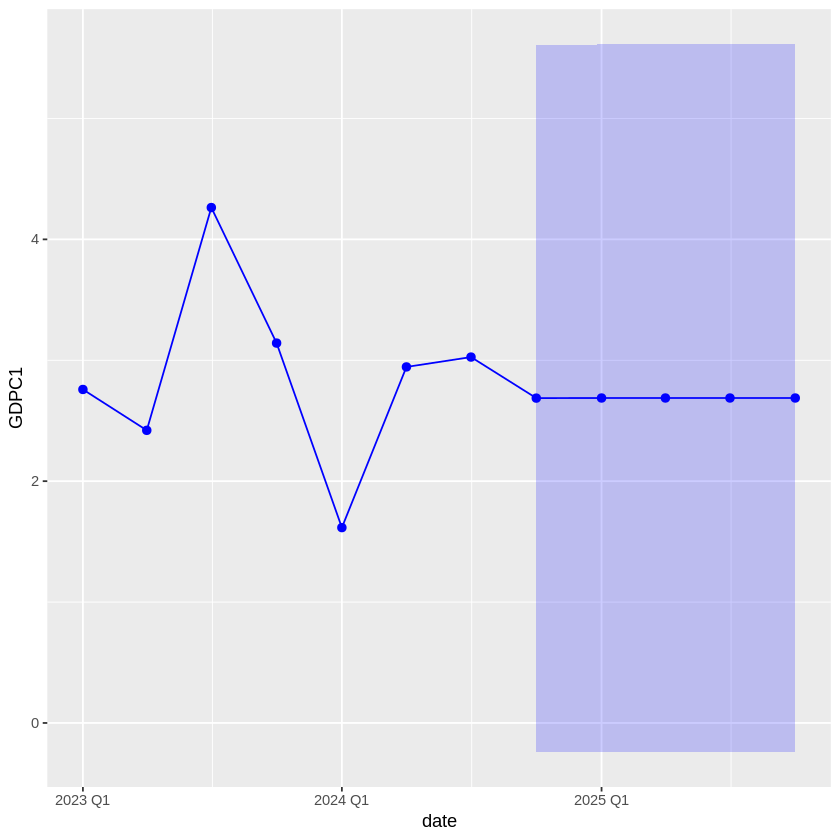

In [181]:
ggplot(plotar, aes(x = date, y = GDPC1)) +
  geom_ribbon(aes(ymin = lower, ymax = upper), fill = "blue", alpha = 0.2) +  # Shaded region for uncertainty
  geom_line(color = "blue") +  # Mean forecast line
  geom_point(size = 2, color = "blue") # Highlight points

In [280]:
var_pred <- tibble(
  GDPC1 = c(2.7371425, 0.1681690, 1.2006864),
  lower = c(0.09302205, -2.72614389, -1.78493432),
  upper = c(5.381263, 3.062482, 4.186307),
  date = c("2025 Q1", "2025 Q2", "2025 Q4")
)
var_pred<-var_pred %>%
  mutate(date=yearquarter(date))

adl_pred <- tibble(
  GDPC1 = c(0.1415071, 0.3244481, 1.370689),
  lower = c(-2.741421, -2.731409, -1.67057),
  upper = c(3.024435, 3.380306, 4.411949),
  date = c("2025 Q1", "2025 Q2", "2025 Q4")
)
adl_pred<-adl_pred %>%
  mutate(date=yearquarter(date))

combined_pred <- tibble(
  GDPC1 = c(1.44, 0.25, 1.37),
  date = c("2025 Q1", "2025 Q2", "2025 Q4"))
combined_pred<-combined_pred %>%
  mutate(date=yearquarter(date))

trs_adl<-transformed %>%
  full_join(adl_pred, by=c("date"="date", "GDPC1"="GDPC1")) %>%
filter(date>=yearquarter("2023 Q1"))

trs_var<-transformed %>%
  full_join(var_pred, by=c("date"="date", "GDPC1"="GDPC1")) %>%
filter(date>=yearquarter("2023 Q1"))

trs_comb<-transformed %>%
  full_join(combined_pred, by=c("date"="date", "GDPC1"="GDPC1")) %>%
filter(date>=yearquarter("2023 Q1"))

Warning message in geom_text(aes(x = yearquarter("2025 Q1"), y = -0.2, label = "ADL"), :
“All aesthetics have length 1, but the data has 10 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(aes(x = yearquarter("2025 Q1"), y = 3, label = "VAR"), :
“All aesthetics have length 1, but the data has 10 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(aes(x = yearquarter("2025 Q1"), y = 1.3, label = "Combined model"), :
“All aesthetics have length 1, but the data has 10 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


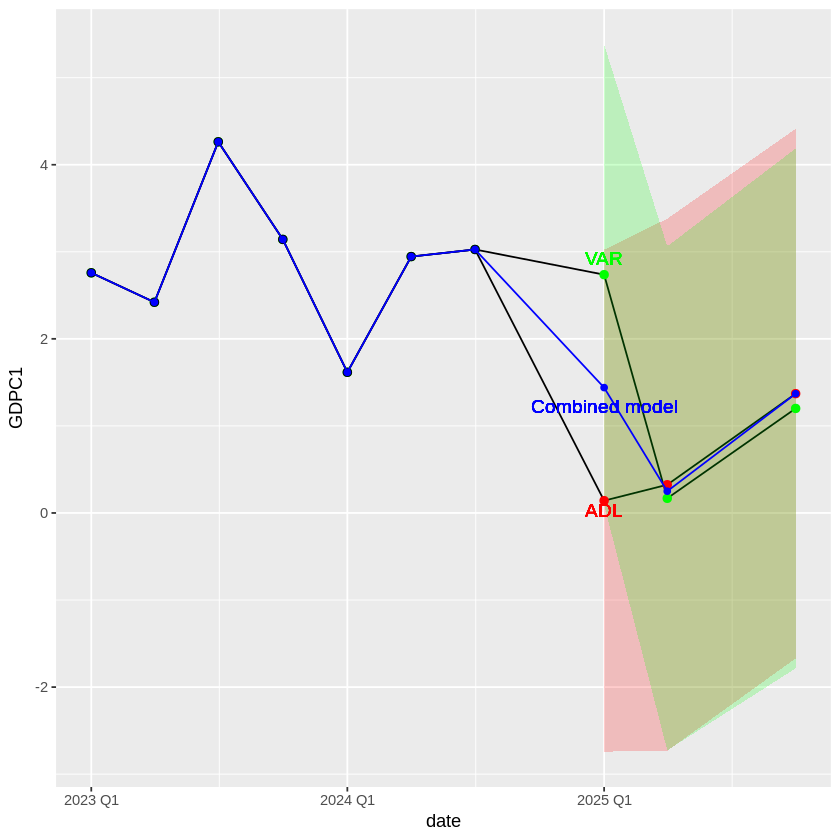

In [297]:
ggplot(trs_adl, aes(x=date, y=GDPC1)) +
  geom_ribbon(aes(x = date, ymin = lower, ymax = upper), fill = "red", alpha = 0.2) +
  geom_line(colour="black") +
  geom_line(data=trs_var) +
  geom_ribbon(data=trs_var, aes(x = date, ymin = lower, ymax = upper), fill = "green", alpha = 0.2) +
  geom_point(data=trs_var, size=2, colour="green") +
  geom_point(aes(colour = if_else(date < yearquarter("2025 Q1"), "black", "red")), size=2) +
  geom_line(data=trs_comb, colour="blue") +
  geom_point(data=trs_comb, colour="blue") +
  scale_colour_manual(values = c("black", "red"))  +
  theme(legend.position = "none") +
  # Add labels
  geom_text(aes(x = yearquarter("2025 Q1"), y = -0.2, label = "ADL"), color = "red", size = 4, vjust = -1) +
  geom_text(aes(x = yearquarter("2025 Q1"), y = 3, label = "VAR"), color = "green", size = 4, vjust = 1) +
  geom_text(aes(x = yearquarter("2025 Q1"), y = 1.3, label = "Combined model"), color = "blue", size = 4, vjust = 1)


In [299]:
contract <- transformed %>%
  filter(GDPC1 < 0) %>%
  select(date) %>%
  mutate(date2 = date + 1)

contract

date,date2
<qtr>,<qtr>
1969 Q4,1970 Q1
1970 Q1,1970 Q2
1970 Q4,1971 Q1
1973 Q3,1973 Q4
1974 Q1,1974 Q2
1974 Q3,1974 Q4
1974 Q4,1975 Q1
1975 Q1,1975 Q2
1980 Q2,1980 Q3


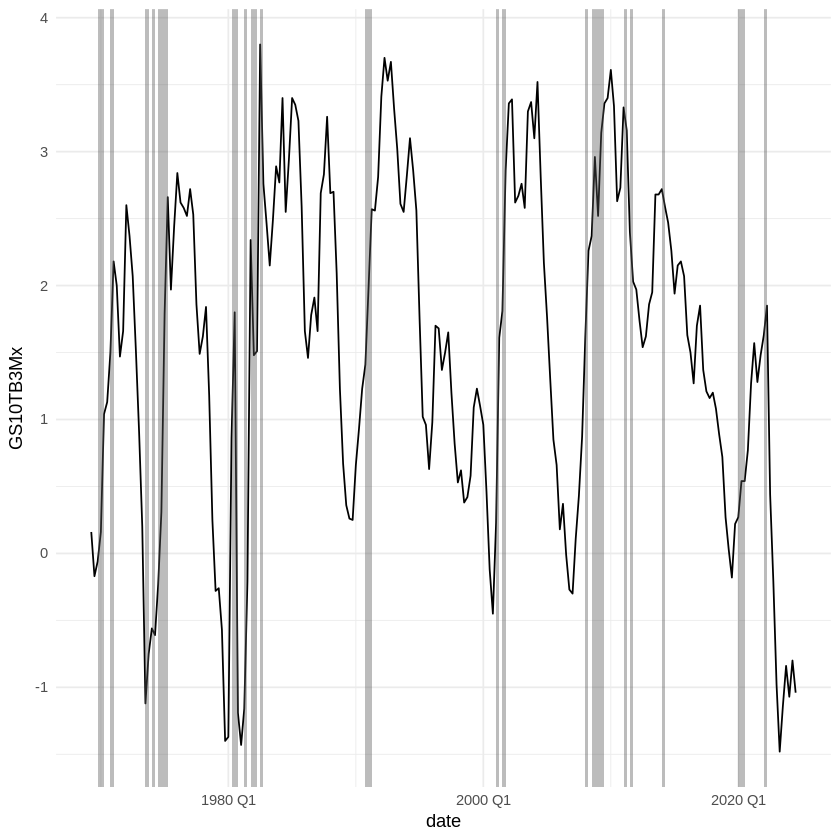

In [300]:
ggplot(transformed, aes(x = date)) +
  geom_line(aes(y = GS10TB3Mx)) +
  geom_rect(data = contract, aes(ymax = Inf, ymin = -Inf, xmin = date, xmax = date2), alpha = 0.4) +
  theme_minimal()

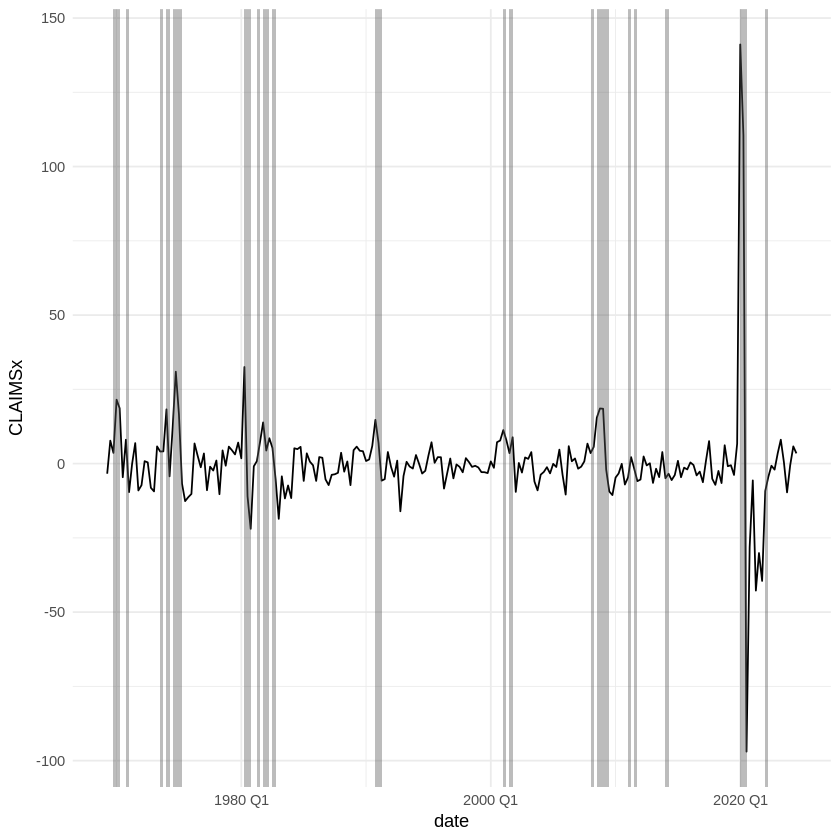

In [301]:
ggplot(transformed, aes(x = date)) +
  geom_line(aes(y = CLAIMSx)) +
  geom_rect(data = contract, aes(ymax = Inf, ymin = -Inf, xmin = date, xmax = date2), alpha = 0.4) +
  theme_minimal()

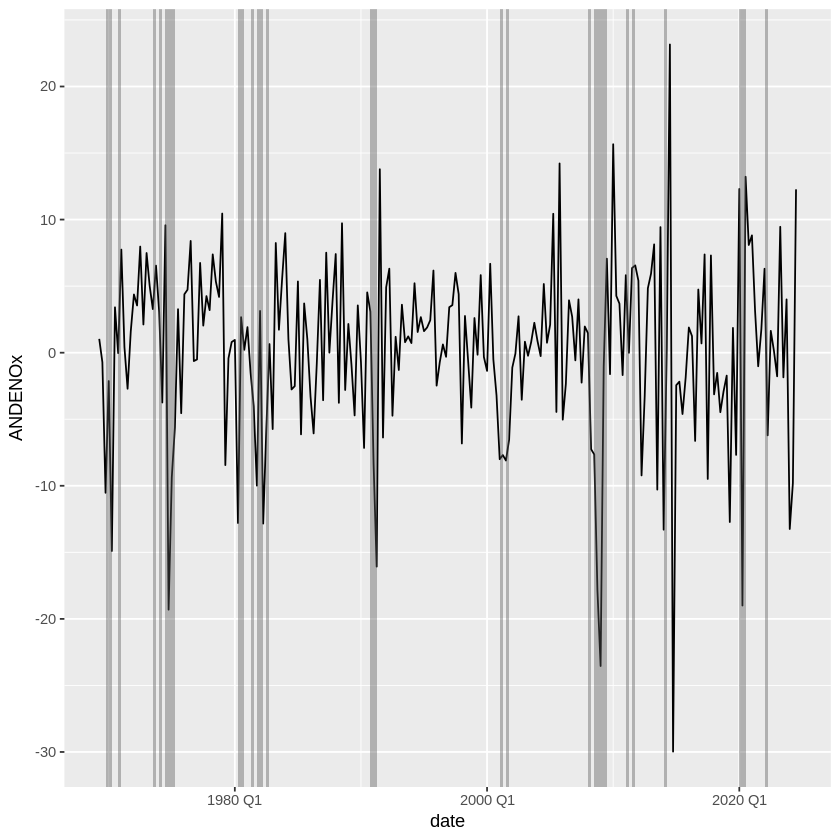

In [302]:
ggplot(transformed, aes(x = date)) +
  geom_line(aes(y = ANDENOx)) +
  geom_rect(data = contract, aes(ymax = Inf, ymin = -Inf, xmin = date, xmax = date2), alpha = 0.4)

In [ ]:
ggplot(transformed, aes(x = date)) +
  geom_line(aes(y = UMCSENTx)) +
  geom_rect(data = contract, aes(ymax = Inf, ymin = -Inf, xmin = date, xmax = date2), alpha = 0.4) +
  theme_minimal()

In [ ]:
ggplot(transformed, aes(x = date)) +
  geom_line(aes(y = HOUST)) +
  geom_rect(data = contract, aes(ymax = Inf, ymin = -Inf, xmin = date, xmax = date2), alpha = 0.4) +
  theme_minimal()

In [ ]:
ggplot(transformed, aes(x = date)) +
  geom_line(aes(y = GDPC1)) +
  geom_rect(data = contract, aes(ymax = Inf, ymin = -Inf, xmin = date, xmax = date2), alpha = 0.4) +
  theme_minimal()